In [21]:
%load_ext autoreload
%reload_ext autoreload

%autoreload 2
%matplotlib inline
import math
import tensorflow
from tensorflow.compat.v1.keras.backend import get_session
tensorflow.compat.v1.disable_v2_behavior()
import kerasAC 
from kerasAC.generators.snp_generator import *
from kerasAC.tiledb_config import *
from scipy.special import softmax
from kerasAC.interpret.deepshap import * 
from kerasAC.interpret.profile_shap import * 
from kerasAC.vis import * 
from kerasAC.helpers.transform_bpnet_io import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
varients=pd.read_csv("variants.with.rsid.bed",header=0,sep='\t')
varients.head()

,Chrom,StartPos,EndPos,Ref,Alt,Rsid
0,chr11,111154071,111154072,A,C,rs7130173
1,chr14,51359099,51359100,C,G,rs72685323
2,chr8,128571854,128571855,G,T,rs4313119
3,chr8,128576703,128576704,T,A,rs12676089
4,chr8,128575521,128575522,C,A,rs7386816


In [3]:
import pyBigWig 
pbw=pyBigWig.open("C_merged.bam.bpnet.unstranded.bw",'r')

In [4]:
#reference allele sequence generator 
ref_gen=SNPGenerator(bed_path="variants.with.rsid.bed",
                 chrom_col="Chrom",
                 pos_col="StartPos",
                 allele_col="Ref",
                 rsid_col='Rsid',
                 flank_size=673,
                 ref_fasta="/mnt/data/male.hg19.fa",
                 expand_dims=False)

#alternate allele sequence generator 
alt_gen=SNPGenerator(bed_path="variants.with.rsid.bed",
                 chrom_col="Chrom",
                 pos_col="StartPos",
                 allele_col="Alt",
                 rsid_col='Rsid',
                 flank_size=673,
                 ref_fasta="/mnt/data/male.hg19.fa",
                 expand_dims=False)


In [135]:
len(ref_gen)

24

In [5]:
#load the model! 
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
from kerasAC.metrics import * 
from kerasAC.custom_losses import * 
custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":ambig_binary_crossentropy,
                    "ambig_mean_absolute_error":ambig_mean_absolute_error,
                    "ambig_mean_squared_error":ambig_mean_squared_error,
                    "MultichannelMultinomialNLL":MultichannelMultinomialNLL}
get_custom_objects().update(custom_objects)
model=load_model("/srv/scratch/annashch/gecco/bpnet/control/bias_corrected_bpnet/bias_corrected_model.0.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
#get the reference allele predictions 
count_preds={} 
profile_preds={} 
snp_to_seq={} 
for i in range(len(ref_gen)):
    print(str(i))
    cur_x=ref_gen[i] 
    batch_rsids=cur_x[0] 
    batch_preds=model.predict(cur_x[1])
    batch_preds_profile=batch_preds[0]
    batch_preds_count=batch_preds[1] 
    for batch_index in range(len(batch_rsids)): 
        cur_rsid=batch_rsids[batch_index]
        snp_to_seq[cur_rsid]={} 
        snp_to_seq[cur_rsid]['ref']=cur_x[1][batch_index,:,:]
        cur_pred_profile=batch_preds_profile[batch_index,:,:]
        cur_pred_count=batch_preds_count[batch_index,:][0]
        count_preds[cur_rsid]={}
        count_preds[cur_rsid]['ref']=cur_pred_count
        profile_preds[cur_rsid]={}
        profile_preds[cur_rsid]['ref']=cur_pred_profile 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [7]:
#get the alternate allele predictions 
for i in range(len(alt_gen)):
    print(str(i))
    cur_x=alt_gen[i] 
    batch_rsids=cur_x[0] 
    batch_preds=model.predict(cur_x[1])
    batch_preds_profile=batch_preds[0]
    batch_preds_count=batch_preds[1] 
    for batch_index in range(len(batch_rsids)): 
        cur_rsid=batch_rsids[batch_index]
        snp_to_seq[cur_rsid]['alt']=cur_x[1][batch_index,:,:]
        cur_pred_profile=batch_preds_profile[batch_index,:,:]
        cur_pred_count=batch_preds_count[batch_index,:][0]
        count_preds[cur_rsid]['alt']=cur_pred_count
        profile_preds[cur_rsid]['alt']=cur_pred_profile 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [8]:
plt.plot(profile_preds[cur_rsid]['ref'])

[<matplotlib.lines.Line2D at 0x7f2f562b0fd0>]

In [9]:
plt.plot(softmax(profile_preds[cur_rsid]['alt'],axis=0))

[<matplotlib.lines.Line2D at 0x7f2e601ae910>]

In [10]:
#pickle the model predictions so we have them for the future 
import pickle 
#dump predictions 
with open("snp_count_preds.p",'wb') as handle: 
    pickle.dump(count_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("snp_profile_preds.p",'wb') as handle: 
    pickle.dump(profile_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
#dump input sequences 
with open("snp_seqs.p",'wb') as handle: 
    pickle.dump(snp_to_seq, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
#convert dictionary to pandas df for easier manipulation 
count_preds_df=pd.DataFrame.from_dict(count_preds,orient='index')
count_preds_df['Alt_Minus_Ref']=count_preds_df['alt']-count_preds_df['ref']
#sort by difference 
count_preds_df=count_preds_df.sort_values(by=["Alt_Minus_Ref"])
count_preds_df.to_csv("tumor_rsid_predictions_alt_and_ref.tsv",header=True,index=True,sep='\t')

print(count_preds_df.head())
print(count_preds_df.tail())

                 ref       alt  Alt_Minus_Ref
rs2523551   8.691921  8.530335      -0.161586
rs61957189  8.981127  8.829374      -0.151752
rs73969443  8.298841  8.156107      -0.142735
rs12590643  8.682210  8.551148      -0.131062
rs6096091   9.145499  9.014537      -0.130962
                  ref       alt  Alt_Minus_Ref
rs151234558  9.514304  9.664939       0.150635
rs11682927   8.827682  8.984152       0.156469
rs4362110    8.500063  8.661660       0.161597
rs6012988    8.683064  8.847634       0.164570
rs9267995    8.722380  8.902603       0.180223


In [12]:
varients.shape

(23601, 6)

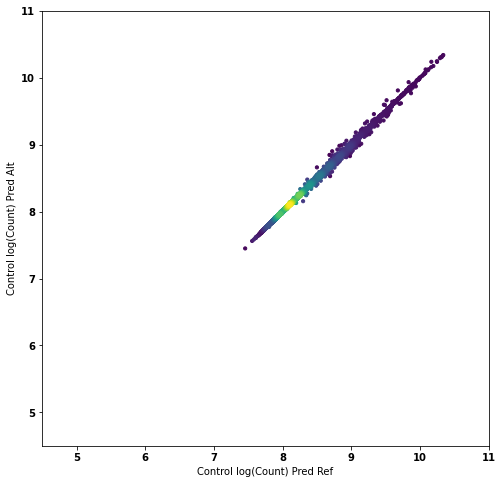

In [27]:
#scatter ref vs alt log(count) pred 
from kerasAC.vis.density_scatter import * 
density_scatter(count_preds_df['ref'],count_preds_df['alt'],'Control log(Count) Pred Ref', 'Control log(Count) Pred Alt',s=10)


In [14]:
from kerasAC.helpers.transform_bpnet_io import * 
import scipy
from scipy.spatial.distance import jensenshannon

## get jensen-shannon distance between profile predictions for ref vs alt 
rsid_to_jsd={} 
for rsid in profile_preds:     
    #convert to probability space 
    ref_profile=softmax(profile_preds[rsid]['ref'],axis=0)
    alt_profile=softmax(profile_preds[rsid]['alt'],axis=0)
    #smooth 
    ref_profile=scipy.ndimage.gaussian_filter1d(ref_profile, 7, axis=0, truncate=(80/14))
    alt_profile=scipy.ndimage.gaussian_filter1d(alt_profile,7,axis=0,truncate=(80/14))
    #get the jsd
    cur_jsd=jensenshannon(ref_profile,alt_profile)
    rsid_to_jsd[rsid]=cur_jsd
#make jsd into dataframe 
#convert dictionary to pandas df for easier manipulation 
jsd_df=pd.DataFrame.from_dict(rsid_to_jsd,orient='index')

In [15]:
jsd_df=jsd_df.rename(columns={0:"JSD"})

In [24]:
#sort by jsd
jsd_df=jsd_df.sort_values(by=["JSD"])
jsd_df.to_csv("tumor_rsid_predictions_alt_and_ref_JSD.tsv",header=True,index=True,sep='\t')

print(jsd_df.head())
print(jsd_df.tail())

                 JSD
rs74819205  0.002261
rs1151139   0.002350
rs7518336   0.002356
rs2357044   0.002391
rs2750482   0.002403
                 JSD
rs13388024  0.104298
rs2766991   0.114168
rs7934321   0.115772
rs9329571   0.139443
rs75622575  0.139543


Text(0.5, 1.0, 'JSD Ref vs Alt, Control')

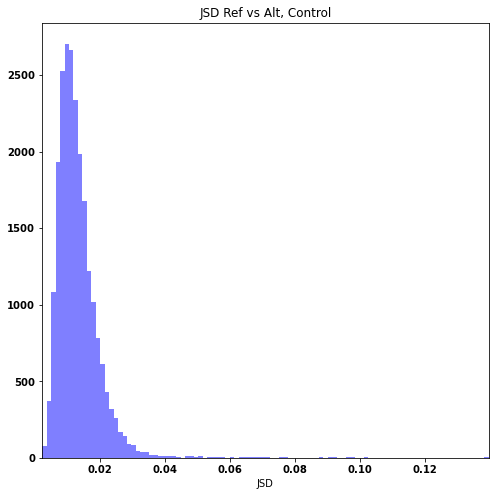

In [26]:
#plot jsd distribution
num_bins=100
plt.rcParams["figure.figsize"]=8,8
plt.figure()
n,bins,patches=plt.hist(jsd_df["JSD"].values,num_bins,facecolor='blue',alpha=0.5)
plt.xlabel('JSD')
plt.title("JSD Ref vs Alt, Control")



In [18]:
#get shap values for the SNPs with the highest delta 

#create the explainers 
model_wrapper=(model.input, model.layers[-1].output)
count_explainer=shap.DeepExplainer(model_wrapper,data=create_background,combine_mult_and_diffref=combine_mult_and_diffref_1d)
prof_explainer = create_explainer(model)

HERE--tf
HERE--keras
here!
here!


In [28]:
## for plotting 
%load_ext autoreload
%reload_ext autoreload

%autoreload 2
%matplotlib inline
import matplotlib 
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,5
plt.rcParams['axes.xmargin'] = 0

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def make_plot(rsid,
              signal,
              count_pred_ref,
              count_pred_alt,
              pred_prob_ref,
              pred_prob_alt,
              profile_explanations_ref, 
              seq_ref,
              profile_explanations_alt,
              seq_alt,
              count_explanations_ref, 
              count_explanations_alt,
              xmin=0,
              xmax=1000,
              ymin_shap=-0.1,
              ymin_perf=-0.1,
              ymax_shap=0.1,
              ymax_perf=0.1):
    plt.rcParams["figure.figsize"]=20,10
    fig, axes = plt.subplots(5, 1)
    axes[0].plot(pred_prob_ref,label='Ref Prob',color='b')
    axes[0].plot(pred_prob_alt,label='Alt Prob',color='r')
    axes[0].plot(signal,label='Label Prob',color='g')
    axes[0].set_title(str(rsid)+"Counts Pred Ref:"+str(count_pred_ref)+":"+"Counts Pred Alt:"+str(count_pred_alt))
    axes[0].legend(loc=4) 
    axes[0].set_xlim(xmin,xmax)
    axes[0].set_ylim(ymin_perf,ymax_perf)
    axes[0].set_xticks(list(range(xmin, xmax, 50,)))    
    
    axes[1]=plot_seq_importance(profile_explanations_ref,seq_ref,xlim=(xmin,xmax),axes=axes[1])
    axes[1].set_title("Profile Loss SHAP, Ref")        
    axes[1].set_ylim(ymin_shap,ymax_shap)
    axes[1].set_xticks(list(range(xmin, xmax, 50,)))    

    axes[2]=plot_seq_importance(profile_explanations_alt,seq_alt,xlim=(xmin,xmax),axes=axes[2])
    axes[2].set_title("Profile Loss SHAP, Alt")        
    axes[2].set_ylim(ymin_shap,ymax_shap)
    axes[2].set_xticks(list(range(xmin, xmax, 50,)))    
    
    
    axes[3]=plot_seq_importance(count_explanations_ref,seq_ref,xlim=(xmin,xmax),axes=axes[3])
    axes[3].set_title("Count Loss SHAP, Ref")        
    axes[3].set_ylim(ymin_shap,ymax_shap)
    axes[3].set_xticks(list(range(xmin, xmax, 50,)))    

    axes[4]=plot_seq_importance(count_explanations_alt,seq_alt,xlim=(xmin,xmax),axes=axes[4])
    axes[4].set_title("Count Loss SHAP, Alt")        
    axes[4].set_ylim(ymin_shap,ymax_shap)
    axes[4].set_xticks(list(range(xmin, xmax, 50,))) 

    plt.subplots_adjust(hspace=0.6)
    plt.show()

In [49]:
len(count_explainer.shap_values(cur_seq_ref))

1

In [62]:
ref_gen[0][1].shape

(1000, 1346, 4)

In [42]:
rsid="rs12896913"
cur_chrom=varients[varients['Rsid']==rsid]['Chrom'].values[0]
cur_pos=varients[varients['Rsid']==rsid]['StartPos'].values[0]
print(cur_chrom)
print(cur_pos)

chr14
54649292


In [43]:
varients[varients['Rsid']==rsid]

,Chrom,StartPos,EndPos,Ref,Alt,Rsid
6117,chr14,54649292,54649293,C,T,rs12896913


In [44]:
#get the signal in probability space 
from sklearn.preprocessing import normalize
flank=500
signal=np.nan_to_num(pbw.values(cur_chrom,cur_pos-flank,cur_pos+flank))
signal=signal/np.sum(signal)
print(signal.shape)


(1000,)


In [45]:
#let's explain the RSID 

signal_sum=math.log(sum(pbw.values(cur_chrom,cur_pos-flank,cur_pos+flank)))

cur_seq_ref=np.expand_dims(snp_to_seq[rsid]['ref'],axis=0)
cur_seq_alt=np.expand_dims(snp_to_seq[rsid]['alt'],axis=0)
count_pred_ref=count_preds[rsid]['ref']
count_pred_alt=count_preds[rsid]['alt']
pred_prob_ref=softmax(profile_preds[rsid]['ref'],axis=0)
pred_prob_alt=softmax(profile_preds[rsid]['alt'],axis=0)
profile_explanations_ref=prof_explainer(cur_seq_ref,None,None)
count_explanations_ref=np.squeeze(count_explainer.shap_values(cur_seq_ref)[0])
profile_explanations_alt=prof_explainer(cur_seq_alt,None,None)
count_explanations_alt=np.squeeze(count_explainer.shap_values(cur_seq_alt)[0])


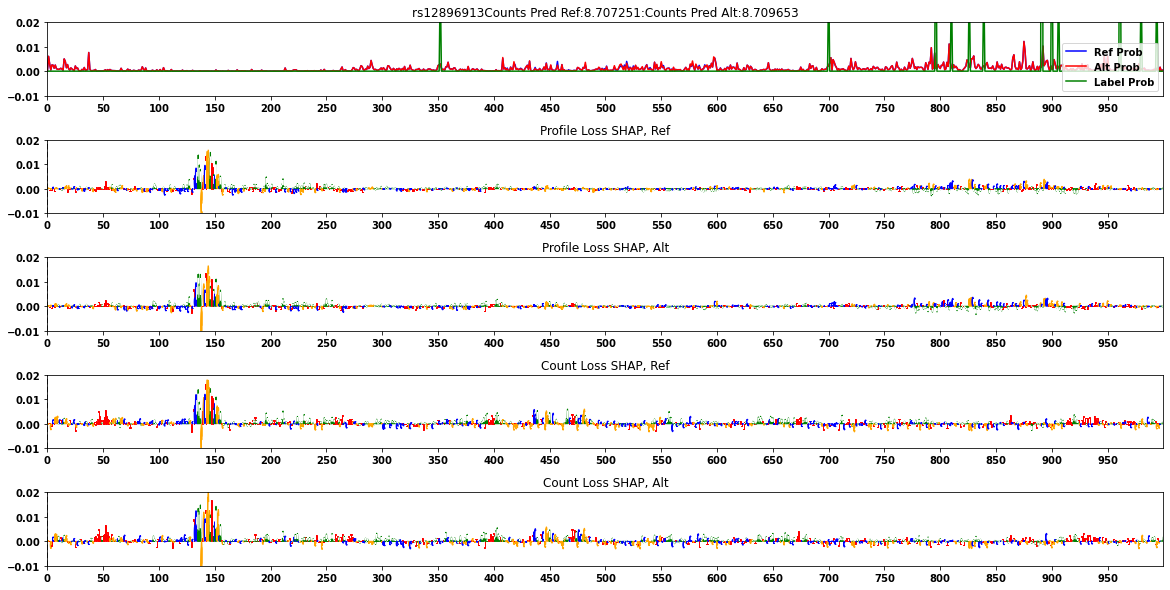

In [46]:
make_plot(rsid,
          signal,
          count_pred_ref,
          count_pred_alt,
          pred_prob_ref,
          pred_prob_alt,
          profile_explanations_ref[:,173:173+1000,:],
          cur_seq_ref[:,173:173+1000,:],
          profile_explanations_alt[:,173:173+1000,:],
          cur_seq_alt[:,173:173+1000,:],
          count_explanations_ref[173:173+1000,:],
          count_explanations_alt[173:173+1000,:],
          xmin=0,
          xmax=1000,
          ymin_shap=-0.01,
          ymin_perf=-0.01,
          ymax_shap=0.02,
          ymax_perf=0.02)

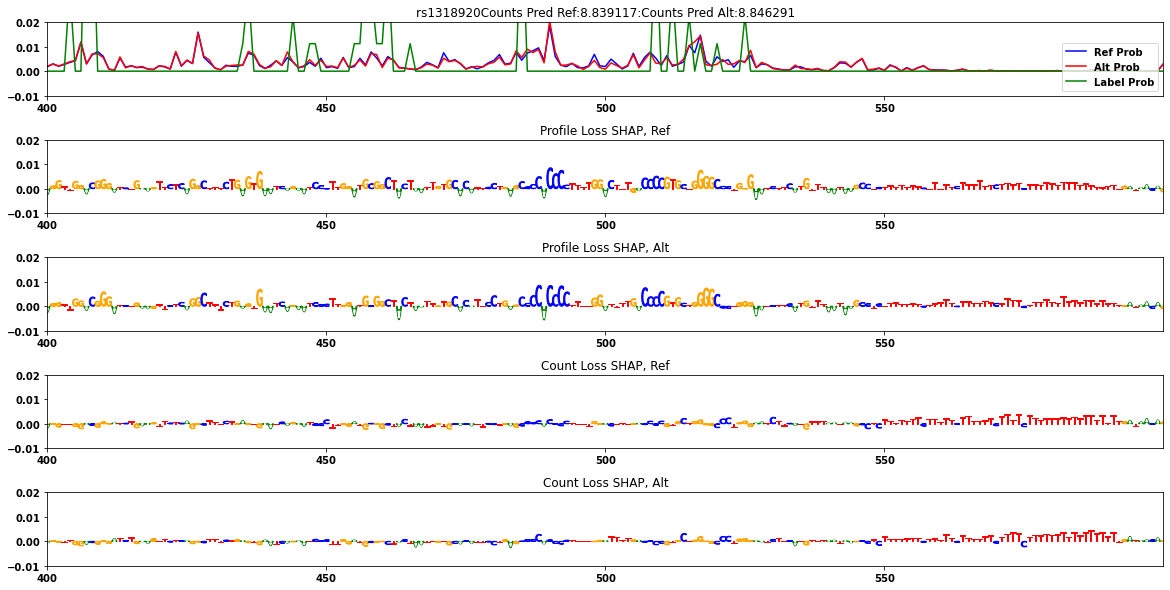

In [36]:
make_plot(rsid,
          signal,
          count_pred_ref,
          count_pred_alt,
          pred_prob_ref,
          pred_prob_alt,
          profile_explanations_ref[:,173:173+1000,:],
          cur_seq_ref[:,173:173+1000,:],
          profile_explanations_alt[:,173:173+1000,:],
          cur_seq_alt[:,173:173+1000,:],
          count_explanations_ref[173:173+1000,:],
          count_explanations_alt[173:173+1000,:],
          xmin=400,
          xmax=600,
          ymin_shap=-0.01,
          ymin_perf=-0.01,
          ymax_shap=0.02,
          ymax_perf=0.02)